In [1]:
import os
import cv2
import numpy as np
from skimage import exposure


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith('.jpg'):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img.flatten())
    return images

def load_images_from_folder_2(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith('.jpg'):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load image in RGB format
            if img is not None:
                # Convert the image to RGB format if it's in BGR format
                if img.shape[2] == 3:  # Check if image is already in RGB format
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    img_rgb = img
                images.append(img_rgb)
    return images


# Folder paths
smile_folder = "archive/smile"
not_smile_folder = "archive/non_smile"
test_folder = 'archive/test'

# Load images from folders
smile_images = load_images_from_folder(smile_folder)
not_smile_images = load_images_from_folder(not_smile_folder)
test_images = load_images_from_folder(test_folder)

# Convert images to numpy arrays
smile_data = np.array(smile_images)
not_smile_data = np.array(not_smile_images)
test_data = np.array(test_images)

print("Number of smile images:", len(smile_data))
print("Number of not-smile images:", len(not_smile_data))
print("Number of test images:", len(test_data))

# Example usage:
# Access smile image data: smile_data[index]
# Access not-smile image data: not_smile_data[index]
print(np.shape(smile_data))

Number of smile images: 600
Number of not-smile images: 603
Number of test images: 12030
(600, 4096)


In [2]:
def trainPerceptron(train_set, train_labels, max_iter):
#     print(train_set)
    dubs = np.zeros((train_set.shape[1]) + 1)
    for iteration in range(max_iter):
        for i, image in enumerate(train_set):
            flat = np.append(image, 1)
            dot1 = np.dot(flat, dubs)
            if train_labels[i] == 0 and dot1 > 0:
                dubs = dubs - 0.03*flat
            elif train_labels[i] == 1 and dot1 <= 0:
                dubs = dubs + 0.03*flat
    W = dubs[:-1]
    b = dubs[-1]
    return W, b

def classifyPerceptron(train_set, train_labels, dev_set, max_iter):
    W, b = trainPerceptron(train_set, train_labels, max_iter)
    ret = []
    for image in dev_set:
        dot = np.dot(W, image) + b
        if dot <= 0:
            ret.append(0)
        elif dot > 0:
            ret.append(1)
    return ret

def classify_smile(W, b, image):
    dot = np.dot(W, image) + b
    if dot <= 0:
        return 0
    else:
        return 1
    


mouth_cascade_path = '/Users/henrythomas/Desktop/ECE420/Final_Project/haarcascade_mouth.xml'
mouth_cascade = cv2.CascadeClassifier(mouth_cascade_path)

def process_image_2(image_array, target_size=(64, 64)):
    # Convert the 1D array to 2D array (64x64 image)
    image = np.reshape(image_array, (64, 64))

    # Convert the image to uint8 for OpenCV
    image_uint8 = np.uint8(image)
    
    lower_half_face = image_uint8[64*5//8:64, 64//6:64-64//6]
    Y = 64*5//8
    X = 64//6
    H = 64 - Y
    W = 64 - 2*X

    # Detect mouths in the image
    mouths = mouth_cascade.detectMultiScale(lower_half_face, scaleFactor=1.2, minNeighbors=8, minSize=(10, 10))

    # If at least one mouth is detected, process the first one
    if len(mouths) > 0:
        (x, y, w, h) = mouths[0]  # Get the coordinates of the first mouth

        # Crop the mouth
        mouth = lower_half_face[y:y + h, x:x + w]

        # Resize the mouth to the target size
        resized_mouth = cv2.resize(mouth, target_size)

        # Flatten the 2D resized mouth to 1D array
        return resized_mouth.flatten()

    # If no mouth is detected, return None
    return None

import mediapipe as mp
import numpy as np
import cv2

# Initialize MediaPipe Mouth Detection
mp_face_mesh = mp.solutions.face_mesh

def process_image_with_mediapipe(image, target_size=(64, 64)):
    # Detect mouth in the image
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results_mouth = face_mesh.process(image)
        if results_mouth.multi_face_landmarks:
            landmarks = results_mouth.multi_face_landmarks[0]
            mouth_points = [landmarks.landmark[idx] for idx in range(13, 21)]  # Mouth landmarks

            # Get the bounding box of the mouth
            mouth_x = min([point.x for point in mouth_points])
            mouth_y = min([point.y for point in mouth_points])
            mouth_width = max([point.x for point in mouth_points]) - mouth_x
            mouth_height = max([point.y for point in mouth_points]) - mouth_y

            # Crop the mouth
            mouth = image_rgb[int(mouth_y*image_rgb.shape[0]):int((mouth_y+mouth_height)*image_rgb.shape[0]),
                               int(mouth_x*image_rgb.shape[1]):int((mouth_x+mouth_width)*image_rgb.shape[1])]

            # Resize the mouth to the target size
            resized_mouth = cv2.resize(mouth, target_size)

            # Flatten the 2D resized mouth to 1D array
            return resized_mouth.flatten()


    # If no mouth is detected or an error occurs, return None
    return None



def normalize_image(image):
    # Reshape image to 2D array of size (64, 64)
    image_2d = np.reshape(image, (64, 64))
    
    # Equalize histogram to improve contrast
    equalized = cv2.equalizeHist(image_2d.astype(np.uint8))
    
    # Flatten image
    flattened = equalized.flatten()
    
    return flattened


def find_mouth_norm(images_array):
    ret_img = []
    non_norm = []
    for i in range(np.shape(images_array)[0]):
        image = process_image_2(images_array[i])
        if image is not None:
            non_norm.append(image)
            normalized_image = normalize_image(image)
            ret_img.append(normalized_image)
    # Convert the list of detected faces to a NumPy array
    print(np.shape(ret_img))
    ret_img = np.array(ret_img, dtype=np.int8)
    return ret_img, non_norm

def move_ave(queue, inp):
    queue.pop(0)
    queue.append(inp)
    return np.mean(queue)


In [3]:
import os
import cv2
import numpy as np
from skimage import exposure

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def trainPerceptron_2(train_set, train_labels, learning_rate, max_iter):
    input_size = train_set.shape[1]
    hidden_size = 16  # Number of neurons in the hidden layer
    
    # Initialize weights and biases for the hidden layer
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    
    # Initialize weights and biases for the output layer
    W2 = np.random.randn(hidden_size)
    b2 = 0
    
    for iteration in range(max_iter):
        for i, image in enumerate(train_set):
            # Forward propagation
            hidden_output = sigmoid(np.dot(image, W1) + b1)
            output = sigmoid(np.dot(hidden_output, W2) + b2)
            
            # Backpropagation
            output_error = train_labels[i] - output
            hidden_error = output_error * sigmoid_derivative(output) * W2
            
            # Update weights and biases using gradient descent
            W2 += learning_rate * hidden_output.flatten() * output_error
            b2 += learning_rate * output_error
            W1 += learning_rate * np.outer(image, hidden_error) * sigmoid_derivative(hidden_output)
            b1 += learning_rate * hidden_error * sigmoid_derivative(hidden_output)
    
    return W1, b1, W2, b2

def classifyPerceptron_2(train_set, train_labels, dev_set, learning_rate, max_iter):
    W1, b1, W2, b2 = trainPerceptron_2(train_set, train_labels, learning_rate, max_iter)
    ret = []
    for image in dev_set:
        hidden_output = sigmoid(np.dot(image, W1) + b1)
        output = sigmoid(np.dot(hidden_output, W2) + b2)
        if output <= 0.5:
            ret.append(0)
        else:
            ret.append(1)
    return ret

def classify_smile_2(W1, b1, W2, b2, image):
    hidden_output = sigmoid(np.dot(image, W1) + b1)
    output = sigmoid(np.dot(hidden_output, W2) + b2)
    if output <= 0.5:
        return 0
    else:
        return 1


In [4]:
smiles, smiles_reg = find_mouth_norm(smile_data)
not_smiles, not_smiles_reg = find_mouth_norm(not_smile_data)
test, test_reg = find_mouth_norm(test_data)

train_set = np.concatenate((smiles, not_smiles))
label_set = np.concatenate((np.ones(np.shape(smiles)[0]), np.zeros(np.shape(not_smiles)[0])))

confirm_set = np.concatenate((smiles[50:60], not_smiles[50:60]))

classify = classifyPerceptron_2(train_set, label_set, test,.001, 20)

print(classify[0:20])
# print(np.mean(classify[0:50]))
# print(np.mean(classify[50:100]))

(396, 4096)
(228, 4096)
(4847, 4096)


/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_25653/2987772923.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


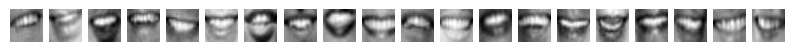

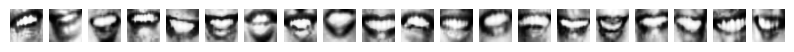

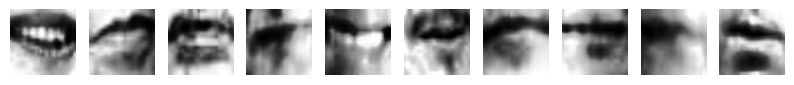

[1, 1, 0, 0, 1, 0, 0, 0, 1, 0]


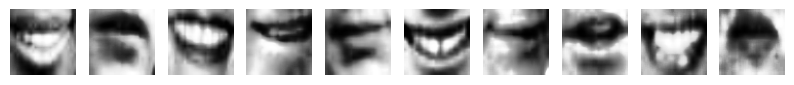

[1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


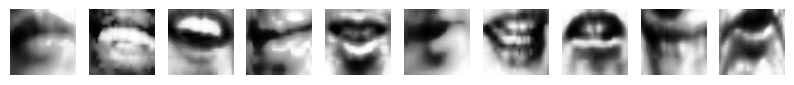

[0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


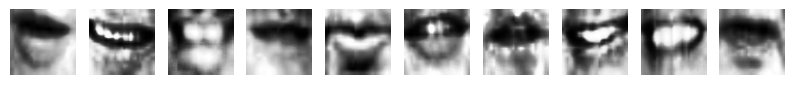

[1, 0, 1, 0, 0, 0, 0, 1, 1, 0]


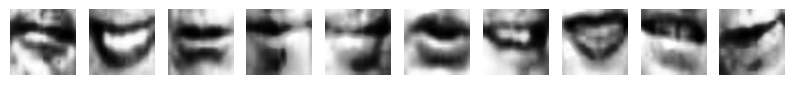

[0, 1, 1, 1, 0, 0, 1, 0, 0, 0]


In [11]:
import matplotlib.pyplot as plt

def show_images(images, n):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.array(images[i].reshape(64, 64), dtype=np.uint8), cmap='gray')
        plt.axis('off')
    plt.show()
    
show_images(smiles_reg, 20)
show_images(smiles, 20)
# show_images(not_smiles, 20)
show_images(test[0:], 10)
print(classify[0:10])
show_images(test[10:20], 10)
print(classify[10:20])
show_images(test[20:30], 10)
print(classify[20:30])
show_images(test[30:40], 10)
print(classify[30:40])
show_images(test[40:50], 10)
print(classify[40:50])

In [7]:
print(np.shape(test))

(4847, 4096)


In [6]:
w1,b1,w2,b2 = trainPerceptron_2(train_set, label_set, .001, 20)

/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_82288/2987772923.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [12]:

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

q = []
q_len = 10
for i in range(q_len):
    q.append(0)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale for face and mouth detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Extract the region of interest (ROI) containing the face
        face_roi = gray[y:y+h, x:x+w]
        lower_half_face = gray[y+h*5//8:y+h, x+w//6:x+w-w//6]
        #cv2.rectangle(frame, (x+w//6, y+h*5//8), (x+w-w//6, y+h), (255, 0, 0), 2)
        X = x+w//6
        Y = y + h*5//8
        W = w - 2*w//6
        H = h - h*5//8

        # Detect mouths within the face region
        mouth = mouth_cascade.detectMultiScale(lower_half_face, scaleFactor=1.2, minNeighbors=12, minSize=(20, 20))
        
        if len(mouth) == 0:
            break
        else:
            mx, my, mw, mh = mouth[0]

            # Draw a rectangle around the detected mouth
            cv2.rectangle(frame, (X+mx, Y+my), (X+mx+mw, Y+my+mh), (0, 255, 0), 2)

            # Extract the mouth region from the face
            mouth_roi = frame[Y+my:Y+my+mh, X+mx:X+mx+mw]

            # Process the mouth image and classify smile
            gray_image = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)
            res = cv2.resize(gray_image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            image = normalize_image(res)
            smile_label = classify_smile_2(w1,b1,w2,b2, image)

            # Display smile label
#             if move_ave(q, smile_label) < 0.5:
#                 cv2.putText(frame, "Smiling", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
#             else:
#                 cv2.putText(frame, "Not Smiling", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    
    # Display the frame
    cv2.imshow('Smile Detection', frame)
    
    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close OpenCV windows
cap.release()
cv2.destroyAllWindows()

/var/folders/hy/kjn0xlds5mn12wjshd4qn57w0000gn/T/ipykernel_82288/2987772923.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [12]:
# weights, bias = trainPerceptron(train_set, label_set, 20)


def numpy_to_java(array):
    if isinstance(array, np.ndarray) and array.ndim == 1:
        java_code = "double[] arrayName = {"
        java_code += ", ".join(str(elem) for elem in array)
        java_code += "};"
        return java_code
    else:
        raise ValueError("Input must be a 1-dimensional NumPy array")
        
def numpy_to_java2d(array, array_name):
    if isinstance(array, np.ndarray) and array.ndim == 2:
        java_code = f"double[][] {array_name} = {{"
        for row in array:
            java_code += "{" + ", ".join(str(elem) for elem in row) + "}"
            java_code += ", "
        java_code = java_code[:-2]  # Remove the last comma and space
        java_code += "};"
        return java_code
    else:
        raise ValueError("Input must be a 2-dimensional NumPy array")

# print(numpy_to_java2d(w1, 'w1'))


In [16]:
import numpy as np

def save_weights_and_biases(W1, b1, W2, b2, file_prefix):
    np.save(file_prefix + "_W1.npy", W1)
    np.save(file_prefix + "_b1.npy", b1)
    np.save(file_prefix + "_W2.npy", W2)
    np.save(file_prefix + "_b2.npy", b2)

# Example usage:
W1 = np.random.randn(10, 8)  # Example weights for the first layer
b1 = np.zeros((1, 8))         # Example biases for the first layer
W2 = np.random.randn(8)       # Example weights for the second layer
b2 = np.zeros(1)              # Example bias for the second layer

save_weights_and_biases(w1, b1, w2, b2, "smile")


In [9]:
weights, bias = trainPerceptron(train_set, label_set, 20)


In [31]:
np.savetxt('w1_smile.csv', w1, delimiter=',')
np.savetxt('b1_smile.csv', b1, delimiter=',')
np.savetxt('w2_smile.csv', w2, delimiter=',')

In [30]:
print(b2)

[0.23020589]
